In [1]:
import torch
import random

import numpy as np
import matplotlib.pyplot as plt
import pretrained_microscopy_models as pmm

import yoeo.comparisons.pmm_helpers as pmm_h

N CPUS: 110


/home/ronan/miniconda3/envs/dv2/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
device = "cuda"
arch: str = "UnetPlusPlus"
encoder: str = "resnet50"
pretrained_weights: str = "micronet"
sparse: bool = True

In [4]:
model = pmm_h.get_model(n_classes=3, arch=arch, encoder=encoder, pretrained_weights=pretrained_weights)

In [5]:
class_values = {'matrix': [85,85,85],
               'secondary': [170,170,170],
               'tertiary' : [255,255,255],
               }
class_values_original = {'matrix': [0,0,0],
               'secondary': [255,0,0],
               'tertiary' : [0,0,255]}
class_values_plus_unlabelled = {'matrix': [85,85,85],
               'secondary': [170,170,170],
               'tertiary' : [255,255,255],
               'unlabelled': [0, 0, 0]}

values = class_values_plus_unlabelled if sparse else class_values

In [6]:
DATA_PATH = "fig_data/CNN_comparison/ni_superalloy"
train_path = f"{DATA_PATH}/train_sparse_annot" if sparse else f"{DATA_PATH}/train_annot"
train_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/train", train_path, "train")
val_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/val", f"{DATA_PATH}/val_annot", "val")
test_ds = pmm_h.get_dataset(values, f"{DATA_PATH}/test", f"{DATA_PATH}/test_annot", "val")

In [7]:
masked_loss = pmm_h.MaskedDiceBCELoss(weight=0.7)
default_loss = pmm.losses.DiceBCELoss(weight=0.7)

loss = masked_loss if sparse else default_loss

In [8]:
n_epochs = 200
save_per = 10
results_dict, state = pmm_h.train_segmentation_model_with_eval(model, arch, encoder, train_ds, val_ds, values, 3, loss, n_epochs, save_per)


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
train:   0%|          | 0/1 [00:00<?, ?it/s]

valid: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s, DiceBCELoss - 0.702] 
[  0/200] (2.022): 0.1654

Epoch: 1, lr: 0.00020000, time: 4.29 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, DiceBCELoss - 0.6972]

Epoch: 2, lr: 0.00020000, time: 2.28 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, DiceBCELoss - 0.693] 

Epoch: 3, lr: 0.00020000, time: 2.08 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, DiceBCELoss - 0.6887]

Epoch: 4, lr: 0.00020000, time: 2.04 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, DiceBCELoss - 0.6848]

Epoch: 5, lr: 0.00020000, time: 2.06 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, DiceBCELoss - 0.6799]

Epoch: 6, lr: 0.00020000, time: 2.16 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 2/2 [00:

In [9]:
# results_dict, state = pmm_h.iteratively_train_cnn(train_ds, val_ds, loss, values, 150, 10, 'iter')

In [10]:
%%capture
print(state['valid_loss'])

plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Text(0.5, 0, 'Time (s)')

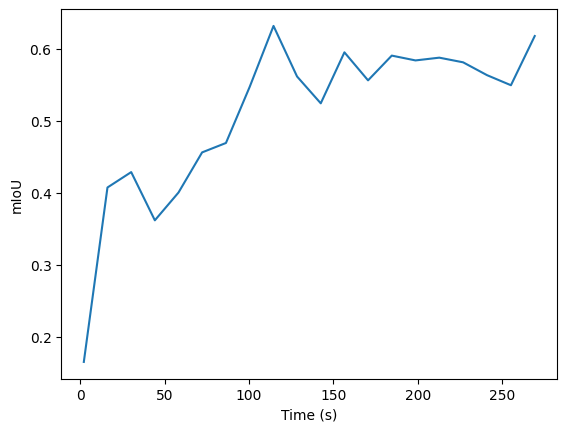

In [11]:
# %%capture
plt.plot([i["tot_time"] for i in results_dict], [i["miou"] for i in results_dict])
plt.ylabel("mIoU")
plt.xlabel("Time (s)")

In [12]:
out_dir = "fig_data/CNN_comparison/ni_superalloy/stored_CNN_results/"
out_path = f"{out_dir}/sparse_data_4_imgs_e{n_epochs}.npy" if sparse else f"{out_dir}/full_data_4_imgs_e{n_epochs}.npy"
np.save(out_path, results_dict)